In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [45]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/Daily_Minimum_Temperatures.csv')
df.head()

,Date,Temp
0,01-01-1981,20.7
1,02-01-1981,17.9
2,03-01-1981,18.8
3,04-01-1981,14.6
4,05-01-1981,15.8


In [4]:
df.tail()

,Date,Temp
2915,26-12-1988,9.5
2916,27-12-1988,12.9
2917,28-12-1988,12.9
2918,29-12-1988,14.8
2919,30-12-1988,14.1


In [ ]:
df.shape

(2920, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2920 non-null   object 
 1   Temp    2920 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.8+ KB


In [46]:
time = pd.date_range(start='1/1/1981',periods=2920,freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Date'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [6]:
df.min()

Temp    0.0
dtype: float64

In [47]:
df = df + 1

In [8]:
plt.rcParams['figure.figsize'] = [15,8]

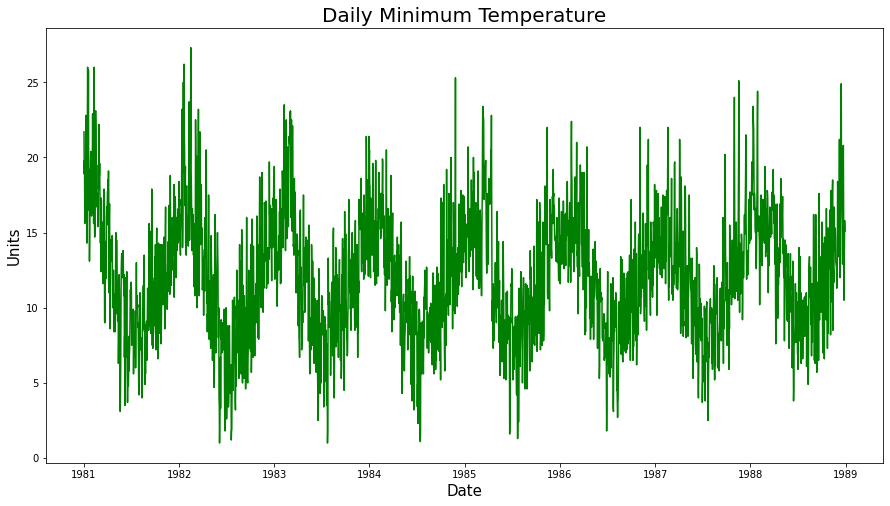

In [9]:
plt.plot(df,color='green')
plt.title('Daily Minimum Temperature',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [48]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [49]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Temp'] = df['Temp'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [50]:
#Split data set into testing dataset and train dataset
train_size = 2628
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 12
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2616, 1, 12)
(2616,)
(280, 1, 12)
(280,)


In [14]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 6.7 MB/s 


In [15]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [16]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('rnn_layer',min_value=4,max_value=96,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.1,0.2,0.3],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=4,max_value=96,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [17]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [18]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [19]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=32,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 46s]
val_mape: 15.021044731140137

Best val_mape So Far: 14.842253684997559
Total elapsed time: 00h 10m 05s
INFO:tensorflow:Oracle triggered exit


In [20]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 44
first_recurrent_dropout: 0.2
dense_layer: 72
Dropout_rate: 0.30000000000000004
learning_rate: 0.0007814271492491678
Score: 14.842253684997559
Trial summary
Hyperparameters:
rnn_layer: 8
first_recurrent_dropout: 0.2
dense_layer: 72
Dropout_rate: 0.1
learning_rate: 0.00227295131667448
Score: 14.898860931396484
Trial summary
Hyperparameters:
rnn_layer: 72
first_recurrent_dropout: 0.2
dense_layer: 52
Dropout_rate: 0.2
learning_rate: 0.00018419138717578804
Score: 15.021044731140137
Trial summary
Hyperparameters:
rnn_layer: 52
first_recurrent_dropout: 0.3
dense_layer: 44
Dropout_rate: 0.5
learning_rate: 0.005341180438864359
Score: 15.028976440429688
Trial summary
Hyperparameters:
rnn_layer: 8
first_recurrent_dropout: 0.3
dense_layer: 4
Dropout_rate: 0.2
learning_rate: 0.007249315109926589
Score: 15.037684440612793
Trial summary
Hyperparam

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [21]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 12))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 44)                2508      
                                                                 
 dense (Dense)               (None, 72)                3240      
                                                                 
 dropout (Dropout)           (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 5,821
Trainable params: 5,821
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [56]:
model = Sequential()
model.add(SimpleRNN(32,activation='relu',input_dim = 12,return_sequences=True,recurrent_dropout=0.1))
model.add(SimpleRNN(8,activation='relu',recurrent_dropout=0.1))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate= 0.00002814271492491678)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 32, epochs = 500,callbacks=[EarlyStopping(monitor='val_loss', patience=150)])

Epoch 1/500
82/82 [==============================] - 36s 6ms/step - loss: 164.0156 - mape: 164.0156 - val_loss: 156.7504 - val_mape: 156.7504
Epoch 2/500
82/82 [==============================] - 0s 3ms/step - loss: 149.2745 - mape: 149.2745 - val_loss: 141.9441 - val_mape: 141.9441
Epoch 3/500
82/82 [==============================] - 0s 3ms/step - loss: 134.0293 - mape: 134.0293 - val_loss: 126.2749 - val_mape: 126.2749
Epoch 4/500
82/82 [==============================] - 0s 3ms/step - loss: 117.9238 - mape: 117.9238 - val_loss: 109.9877 - val_mape: 109.9877
Epoch 5/500
82/82 [==============================] - 0s 3ms/step - loss: 101.3658 - mape: 101.3658 - val_loss: 93.6172 - val_mape: 93.6172
Epoch 6/500
82/82 [==============================] - 0s 3ms/step - loss: 85.1828 - mape: 85.1828 - val_loss: 77.7781 - val_mape: 77.7781
Epoch 7/500
82/82 [==============================] - 0s 3ms/step - loss: 70.6227 - mape: 70.6227 - val_loss: 64.6139 - val_mape: 64.6139
Epoch 8/500
82/82 [===

In [58]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [59]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 15.51 
Test MAPE : 15.37 


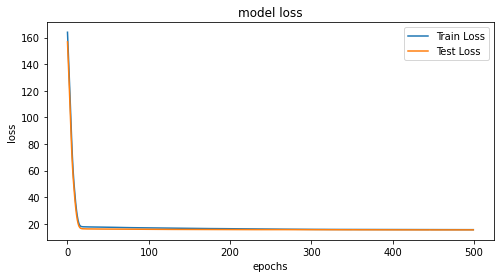

In [60]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [32]:
import seaborn as sns

In [61]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(2616,2896)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

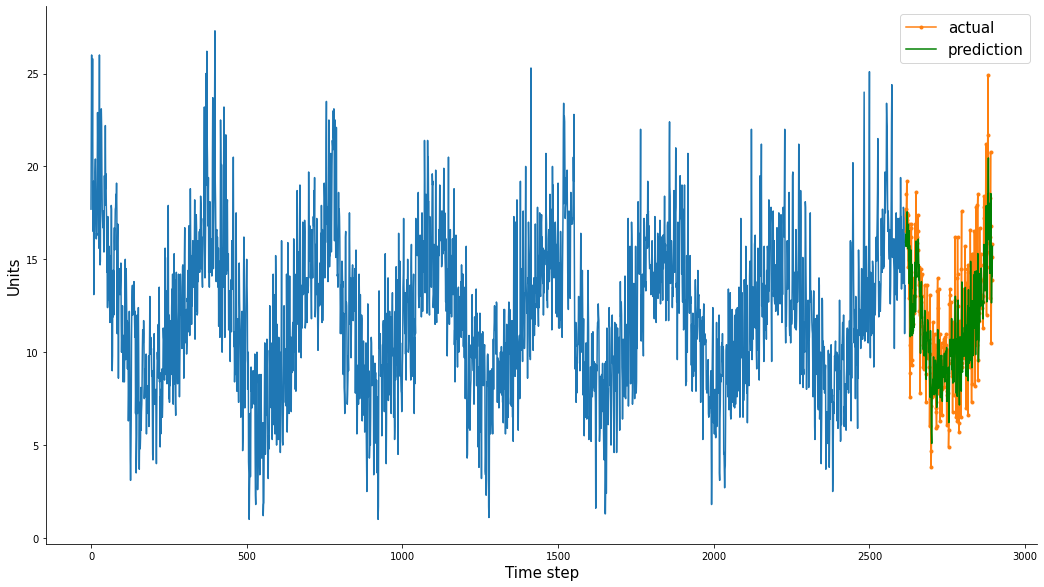

In [62]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)